# Libraries

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os

# Skeletonization (Zhang-Suen Algorithm)

In [10]:
# Define the Zhang-Suen thinning algorithm with saving intermediate steps
def zhang_suen_thinning(image):
    def neighbours(x, y, image):
        """Return 8-neighbours of image point P1(image[x,y]), in a clockwise order"""
        img = image
        return [img[x-1, y], img[x-1, y+1], img[x, y+1], img[x+1, y+1],
              img[x+1, y], img[x+1, y-1], img[x, y-1], img[x-1, y-1]]

    def transitions(neighbours):
        """Number of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"""
        n = neighbours + neighbours[0:1]  # P2, P3, P4, P5, P6, P7, P8, P9, P2
        return sum((n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]))

    def zhang_suen_iteration(image, iter):
        """Perform one iteration of the Zhang-Suen thinning algorithm"""
        changing = []
        rows, columns = image.shape
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2, P3, P4, P5, P6, P7, P8, P9 = neighbours(x, y, image)
                if (image[x, y] == 1 and
                    2 <= sum([P2, P3, P4, P5, P6, P7, P8, P9]) <= 6 and
                    transitions([P2, P3, P4, P5, P6, P7, P8, P9]) == 1 and
                    ((P2 * P4 * P6 == 0 and P4 * P6 * P8 == 0) if iter == 0 else
                     (P2 * P4 * P8 == 0 and P2 * P6 * P8 == 0))):
                    changing.append((x, y))
        for x, y in changing:
            image[x, y] = 0
        return image, changing

    img = image.copy()
    prev_img = np.zeros(img.shape)
    steps = []

    while not np.array_equal(img, prev_img):
        prev_img = img.copy()
        img, changing = zhang_suen_iteration(img, 0)
        steps.append(changing)
        img, changing = zhang_suen_iteration(img, 1)
        steps.append(changing)

    return img, steps

# Reconstruct

In [11]:
def skeleton_to_binary(skeleton_image):
    # Initialize an array of zeros with the same shape as the skeletonized image
    reconstructed_image = np.zeros_like(skeleton_image)
    rows, columns = skeleton_image.shape
    for x in range(1, rows - 1):
        for y in range(1, columns - 1):
            # Check if the current pixel is part of the skeleton
            if skeleton_image[x, y] == 1:
                # Set the current pixel and its neighbors to 1 in the reconstructed image
                reconstructed_image[x-1:x+2, y-1:y+2] = 1

    return reconstructed_image

In [12]:
# Arrays to store images and results
original_images = []
binary_images = []
skeleton_images = []

# Directory containing the images
image_dir = 'images'

# List of image filenames
image_filenames = os.listdir(image_dir)

# Iterate over images to extract skeleton
for filename in image_filenames:
    # Read the image in grayscale
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was correctly read
    if image is None:
        print(f"Failed to read {filename}")
        continue

    # Convert the image to binary
    _, binary_image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)

    # Print the shape of the binary image for debugging
    print(f"Processing {filename} with shape {binary_image.shape}")

    # Apply Zhang-Suen Thinning
    skeleton, steps = zhang_suen_thinning(binary_image)

    # Save original, binary and skeleton images to arrays
    original_images.append(image)
    binary_images.append(binary_image)
    skeleton_images.append(skeleton)

Processing q8_6.png with shape (800, 800)
Processing q8_5.jpg with shape (472, 378)
Processing q8_7.png with shape (200, 176)


# Plotting

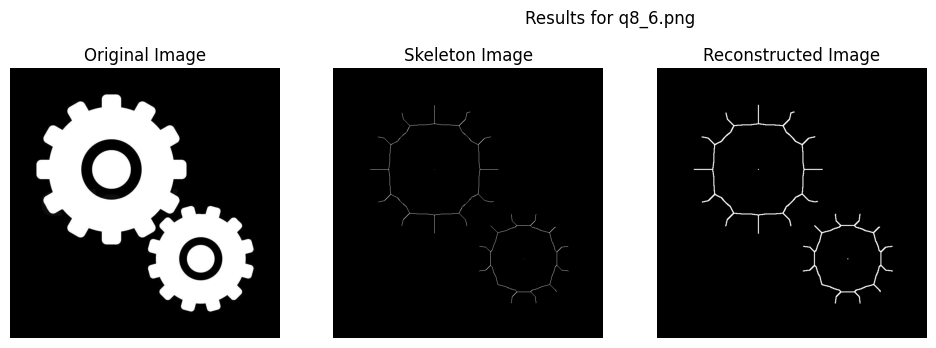

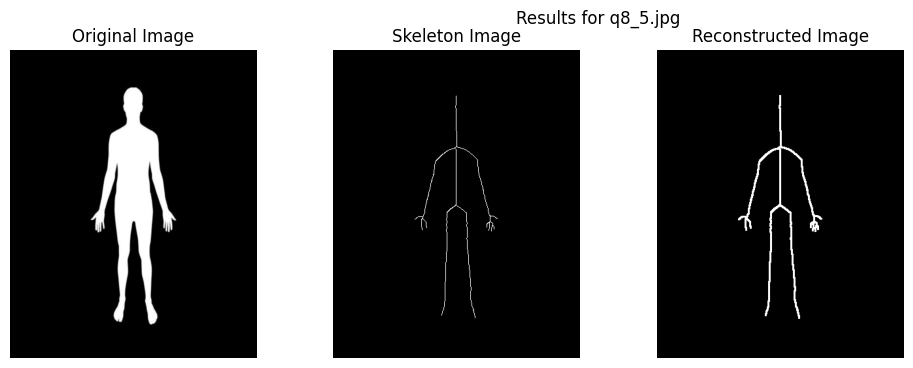

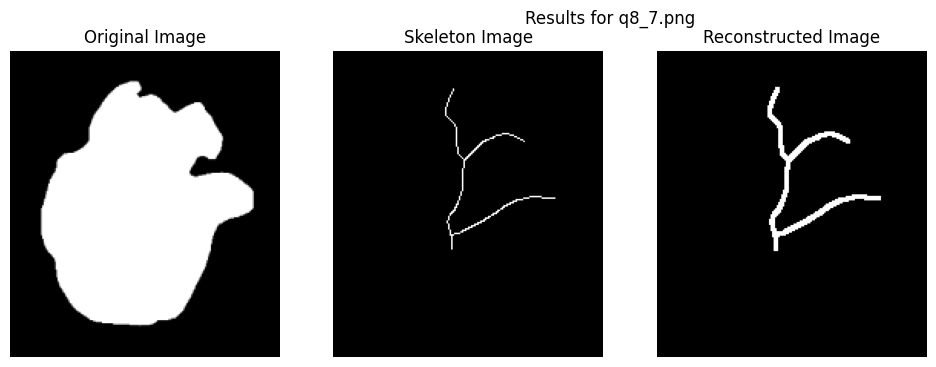

In [14]:
# Display the results using matplotlib
for i, filename in enumerate(image_filenames):
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(original_images[i], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title('Skeleton Image')
    plt.imshow(skeleton_images[i], cmap='gray')
    plt.axis('off')

    # Reconstruct the original image from the skeleton and steps
    reconstructed_image = skeleton_to_binary(skeleton_images[i])

    plt.subplot(1, 4, 3)
    plt.title('Reconstructed Image')
    plt.imshow(reconstructed_image, cmap='gray')
    plt.axis('off')

    plt.suptitle(f"Results for {filename}")
    plt.show()